## 도구 호출 에이전트(Tool Calling Agent)

도구 호출을 사용하면 모델이 하나 이상의 도구가 호출되어야 하는 시기를 감지하고 해당 도구에 전달해야 하는 입력으로 전달 가능.<br>
API 호출에서도 도구를 설명하고 모델이 이러한 도구를 호출하기 위한 인수가 포함된 JSON과 같은 구조화된 객체를 출력하도록 지능적으로 선택 가능.<br>
도구 API의 목표는 일반 텍스트 완성이나 채팅 API를 사용하여 수행할 수 있는 것보다 더 안정적이고 유효하고 유용한 도구 호출(tool call)을 반환하는 것. <br>
이러한 구조화된 출력을 도구 호출 채팅 모델에 여러 도구를 바인딩하고 모델이 호출할 도구를 선택할 수 있다는 사실과 결합하여 쿼리가 해결할 때까지 반복적으로 도구를 호출하고<br>
결과를 수신하는 에이전트를 만들 수 있다.<br>

In [1]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-Agents")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agents


In [2]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL


# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


# 도구 생성
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result


print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


In [3]:
# tools 정의
tools = [search_news, python_repl_tool]

### Agent 프롬프트 생성
- chat_history: 이전 대화 내용을 저장하는 변수(멀티턴을 지원하지 않는다면, 생략 가능)
- agent_scratchpad: 에이전트가 작업을 수행하는 과정을 저장하는 변수
- input: 사용자의 입력

In [4]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

In [5]:
# Agent 생성
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# LLM 정의
llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0)

agent = create_tool_calling_agent(llm, tools, prompt)

### AgentExecutor

도구를 사용하는 에이전트를 실행하는 클래스
- agent: 실행 루프의 각 단게에서 계획을 생성하고 행동을 결정하는 에이전트
- tools: 에이전트가 사용할 도구 목록
- return_intermediate_steps: 중간 단계의 결과를 반환할지 여부
- max_iterations: 실행 루프를 종료하기 전 최대 단계 수
- max_execution_time: 실행 루프에 소요될 수 있는 최대 시간
- early_stopping_method: 에이전트가 AgentFinish를 반환하지 않을 때 사용할 조기 종료 방법("force" or "generate")
    - "force": 시간 또는 반복 제한에 도달하여 중지되었다는 문자열을 반환
    - "generate": 에이전트 LLM 체인을 마지막으로 한 번 호출하여 이전 단계에 따라 최종 답변 생성.
- handle_parsing_error: 에이전트 출력 파서에서 발생한 오류 처리 방법(True, False, 또는 오류 처리 함수)
- trim_intermediate_steps: 중간 단계를 트리밍하는 방법(-1 trim 하지 않음, 또는 트리밍 함수)

주요 메서드
- invoke: 에이전트 실행
- stream: 최종 출력에 도달하는 데 필요한 단계를 스트리밍

주요 기능
1. 도구 검증: 에이전트와 호환되는 도구인지 확인
2. 실행 제어: 최대 반복 횟수 및 실행 시간 제한 설정 가능
3. 오류 처리: 출력 파싱 오류에 대한 다양한 처리 옵션 제공
4. 중간 단계 관리: 중간 단계 트리밍 및 반환 옵션

최적화 팁
- max_iterations과 max_execution_time을 적절히 설정하여 실행 시간 관리
- trim_intermediate_steps를 활용하여 메모리 사용량 최적화
- 복잡한 작업의 경우 stream 메서드를 사용하여 단계별 결과 모니터링

In [6]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(
    agent=agent, 
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
    )

result = agent_executor.invoke({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})
print("Agent 실행결과:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTE1ETFZJLXhuMTB6aVZWRGUzUjRnN2VqRGpDcVJ3c1EtWTBsQ2E3UzI1T09tX2tIaDJUU1FHVUdBcHNrMjhCZXpXTHlVRXI2RndISTJBYTJzcExnYVY1Nm1Qd0JPckJSOUx5UEE?oc=5', 'content': 'AI 거품 논란 불구 3분기도 생성 AI 투자 지속...5.3조 몰려 - AI타임스'}, {'url': 'https://news.google.com/rss/articles/CBMiW0FVX3lxTFBwdjVySDNteG5Ba0xJY0p6a1l6djRaUzBFSEVuN3JyS2l1VS1qd3hnTlZNZ0xwaDliSkVyeHhyWE82YVBrS1NLOHk5MldkQUtsR3FnOVMxbzJqVm_SAV5BVV95cUxOMzF5ellGT05uMkhsOXlxRGZlZTJOTjY0Z1JGZ28yYWJlNWExQXVFUm1aQXZxZ1pvTFFxUURsVTlJclJTajRvMGFwLVNfa1ZYVzRhTFhLOElDQUktNEtn?oc=5', 'content': "美, '대중국 AI 투자제한' 규칙안 막판 검토…대선 전 발표할 듯 - 연합뉴스"}, {'url': 'https://news.google.com/rss/articles/CBMiU0FVX3lxTE9ROGJWcFJuT296N1dDMVVkRGxXdVpnaklScEtkWkFvaVprWjk4VlVHYnZVRU9pQzJOWjlCa0Vpa1NIMnZaSFg0SmdVdkQ4RnE0U0dJ?oc=5', 'content': '"AI 투자는 \'타이거 ETF\'로 하세요"…미래에셋, 투자 가이드북 발간 - 서울경제신문'}, {'url': 'https://news.google.com/rss

In [8]:
# Stream 출력으로 실행
result = agent_executor.stream({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})
for chunk in result:
    print(chunk)



> Entering new AgentExecutor chain...
{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI 투자'}, log="\nInvoking: `search_news` with `{'query': 'AI 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_5FEqf15gvmhyizTIti98kWk8', 'function': {'arguments': '{"query":"AI 투자"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc'}, id='run-95e08916-33bd-4cfc-84d4-4ff0948941b7', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI 투자'}, 'id': 'call_5FEqf15gvmhyizTIti98kWk8', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI 투자"}', 'id': 'call_5FEqf15gvmhyizTIti98kWk8', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_5FEqf15gvmhyizTIti98kWk8')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id'

AgentExecutor의 `stream()` 메소드를 사용하여 에이전트의 중간 단계를 스트리밍.<br>
`stream()`의 출력은 (Action, Observation) 쌍 사이에서 번갈아 나타나며, 최종적으로 에이전트가 목표를 달성했다면 답변으로 마무리.<br>
1. Action 출력
2. Observation 출력
3. Action 출력
4. Observation 출력<br>
... (목표 달성까지 계속) ...<br>

그 다음, 최종 목표가 달성되면 에이전트는 최종 답변을 출력.<br>
이러한 출력의 내용은 다음과 같이 요약.<br>
 출력 | 내용 |
|------|------|
| Action | `actions`: AgentAction 또는 그 하위 클래스<br>`messages`: 액션 호출에 해당하는 채팅 메시지 |
| Observation | `steps`: 현재 액션과 그 관찰을 포함한 에이전트가 지금까지 수행한 작업의 기록 |
| Final Answer | `output`: AgentFinish<br>`messages`: 최종 출력을 포함한 채팅 메시지 |

In [9]:
# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True,
    )

In [11]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()

Python REPL can execute arbitrary code. Use with caution.


[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'lightcoral', 'lightskyblue', 'yellowgreen']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'lightcoral', 'lightskyblue', 'yellowgreen']\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Sample Pie Chart')\nplt.show()"}`





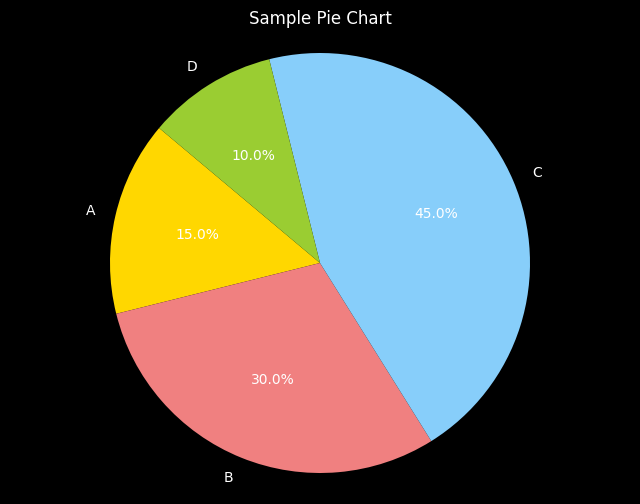

[관찰 내용]
Observation: 
[최종 답변]
파이 차트가 성공적으로 그려졌습니다. 차트에는 A, B, C, D라는 네 가지 카테고리가 포함되어 있으며, 각 카테고리의 비율이 표시되어 있습니다. 차트의 제목은 "Sample Pie Chart"입니다. 

추가적인 질문이나 다른 요청이 있으시면 말씀해 주세요!


In [12]:
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)
for step in result:
    agent_stream_parser.process_agent_steps(step)

In [17]:
# AgentCallbacks와 AgentStreamParser를 langchain_teddynote.messages에서 가져옵니다.
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}\n\n")  # 사용된 도구의 이름을 출력합니다.


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(
        f"Observation: {observation.get('observation')[0]}\n\n"
    )  # 관찰 내용을 출력합니다.



# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(f"{result}\n\n")  # 최종 답변을 출력합니다.


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

In [18]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "AI 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news


<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTE1ETFZJLXhuMTB6aVZWRGUzUjRnN2VqRGpDcVJ3c1EtWTBsQ2E3UzI1T09tX2tIaDJUU1FHVUdBcHNrMjhCZXpXTHlVRXI2RndISTJBYTJzcExnYVY1Nm1Qd0JPckJSOUx5UEE?oc=5', 'content': 'AI 거품 논란 불구 3분기도 생성 AI 투자 지속...5.3조 몰려 - AI타임스'}


<<<<<<< 최종 답변 >>>>>>
다음은 AI 투자와 관련된 최근 뉴스 기사들입니다:

1. [AI 거품 논란 불구 3분기도 생성 AI 투자 지속...5.3조 몰려 - AI타임스](https://news.google.com/rss/articles/CBMiakFVX3lxTE1ETFZJLXhuMTB6aVZWRGUzUjRnN2VqRGpDcVJ3c1EtWTBsQ2E3UzI1T09tX2tIaDJUU1FHVUdBcHNrMjhCZXpXTHlVRXI2RndISTJBYTJzcExnYVY1Nm1Qd0JPckJSOUx5UEE?oc=5)

2. [美, '대중국 AI 투자제한' 규칙안 막판 검토…대선 전 발표할 듯 - 연합뉴스](https://news.google.com/rss/articles/CBMiW0FVX3lxTFBwdjVySDNteG5Ba0xJY0p6a1l6djRaUzBFSEVuN3JyS2l1VS1qd3hnTlZNZ0xwaDliSkVyeHhyWE82YVBrS1NLOHk5MldkQUtsR3FnOVMxbzJqVm_SAV5BVV95cUxOMzF5ellGT05uMkhsOXlxRGZlZTJOTjY0Z1JGZ28yYWJlNWExQXVFUm1aQXZxZ1pvTFFxUURsVTlJclJTajRvMGFwLVNfa1ZYVzRhTFhLOElDQUktNEtn?oc=5)

3. [\"AI 투자는 '타